# Read data
## Setup notebook

In [1]:
phenotype = 'age3'  # see list below
method = "tangent"
atlas_dimension = 64 #Sizes: 64, 128, 256

## Read phenotypes from excel

In [3]:
import pandas as pd

#I have 3 excel filles based on the ammount of missing data for the phenotypes (all in folder Lables)
#File demo_paper_data.xlsx is for phenotypes 0-3
#File demo_paper_data_missing.xlsx is for phenotypes 4 and 5
#File demo_paper_data_missing_marit.xlsx is for phenotypes 6, 7, 8

pheno_columns = {
    'age3': "Age groups (0-60:69, 1:70:79, 2-80:100+)",
    'age_bin2': "Age groups (0-60:74, 1:75-100+)",
    'sex': "Sex of subject at birth (0-M, 1-F)",    
    'yrs_edu': "Education groups (0-7:15, 1-16:18, 2-19+)",
    'yrs_edu_bin':"Education groups (0-7:18, 1-19+)",
    'hand_bin': "Handedness (0:L, 1:R)",
    'race_bin': "Race (0:White, 1:Other)",
    'lang_bin':"Languages (0:Monolingual, 1:Multilingual)",
    'married_bin': "Marital status (0:not married or never married, 1:married)",
    'parity_bin': "How many children do you have? (0:0, 1:1 or more)",
    'employ_steady': "Employed (0: steady employed, 1: unsteady employed)",
    'child_sex': "Do you have children and what is your sex? (0-M, 0 children, 1-M, children, 2-F, 0 children, 3-F,children)",
}

path_to_excel = "demo_data_bin_test.xlsx" #New labels: demo_data_bin, demo_data_bin_missing, demo_data_bin_missing_marit
df_meta = pd.read_excel(path_to_excel)

In [4]:
df_meta

,Subject ID how it's defined in lab/project,"Age groups (0-60:79, 1-80:100+)","Age groups (0-60:69, 1:70:79, 2-80:100+)","Age groups (0-60:69, 1-70:100+)","Age groups (0-60:65, 1-66:100+)","Age groups (0-60:74, 1:75-100+)","Sex of subject at birth (0-M, 1-F)","Education groups (0-7:15, 1-16:18, 2-19+)","Education groups (0-7:19, 1-20+)","Education groups (0-7:12, 1-13+)",...,"Race (0:White, 1:Other)","Languages (0:1, 1:2, 2:3 and more)","Languages (0:Monolingual, 1:Multilingual)","Marital status (0:not married, 1:married, 2:divorced, widowed, separated)","Marital status (0:not married or never married, 1:married)","How many children do you have? (0:0, 1:1 or 2, 2:more than 2)","How many children do you have? (0:0, 1:1 or more)","Do you have children and what is your sex? (0-M, 0 children, 1-M, children, 2-F, 0 children, 3-F,children)","Employed (0: not employed, 1: employed at least 6 months)","Employed (0: steady employed, 1: unsteady employed)"
0,HCA6058970,0,1,1,1,1,1,1,0,1,...,0,0,0,2,0,2,1,3,1,0
1,HCA6061757,1,2,1,1,1,1,2,0,1,...,0,0,0,2,0,1,1,3,0,0
2,HCA6062456,1,2,1,1,1,1,1,0,1,...,0,0,0,2,0,2,1,3,0,0
3,HCA6075263,0,0,0,0,0,0,2,0,1,...,0,0,0,1,1,1,1,1,1,1
4,HCA6086369,0,1,1,1,1,0,2,1,1,...,0,0,0,1,0,0,0,0,1,1
5,HCA6086975,1,2,1,1,1,0,2,0,1,...,0,1,1,1,1,1,1,1,1,1
6,HCA6089375,0,1,1,1,1,1,0,0,1,...,1,1,1,2,0,2,1,3,0,0
7,HCA6091766,0,1,1,1,0,0,2,0,1,...,0,0,0,1,1,1,1,1,0,0
8,HCA6095572,0,1,1,1,0,1,1,0,1,...,0,0,0,2,0,2,1,3,0,0
9,HCA6098073,0,2,1,1,1,1,1,0,1,...,0,0,0,2,0,2,1,3,0,0


## Read connectome


There are also 3 versions of connectomes based on phenotypes you choose to rank (all in the folder Connectomes)
XSTAN_ is for phenotypes 0-3, XSTANMIS_race_ is for phenotypes 4 and 5 and XSTANMIS_marit_child_ is for phenotypes 6-8
The data has been sliced; connectomes for 128 and 256 atlases to 2000 features and 64 atlas to 700 features.
I also sliced Ranked data to be the same length as connectomes, however I did not precomputed them (to contain features retained when slicing connectomes). 

In [5]:
import numpy as np

dimension_of_atlas = 64

X = np.load(f"connectome/connectomes_{dimension_of_atlas}.npy")
print("connectomes_" + str(atlas_dimension) + ".npy has been loaded.")

connectomes_64.npy has been loaded.


### LABELS

In [6]:
# Parameters
n_chunks_per_subject = 10
n_subjects = len(df_meta)
assert X.shape[0] == n_subjects * n_chunks_per_subject, "Mismatch between X and label dimensions."

# Repeat labels for each chunk per subject
column_name = pheno_columns[phenotype]
subject_labels = df_meta[column_name].values
y = np.repeat(subject_labels, n_chunks_per_subject)

## Inspect class imbalance

In [7]:
n_samples, n_features = X.shape
print(f'n_samples: {n_samples}')
print(f'n_features: {n_features}')

classes, counts = np.unique(y, return_counts=True)
for cls, cnt in zip(classes, counts):
    print(f'class {cls}: {cnt} instances ({100*cnt/len(y):.2f}%)')

n_samples: 140
n_features: 2080
class 0: 10 instances (7.14%)
class 1: 60 instances (42.86%)
class 2: 70 instances (50.00%)


# Define model

In [8]:
from sklearn.pipeline import Pipeline
from util import RankMrMr, SelectFirstKFeatures
from sklearn.neighbors import NeighborhoodComponentsAnalysis, KNeighborsClassifier
import sklearn

sklearn.set_config(enable_metadata_routing=True)
# Necessary to pass sample weights through cross validation for hyperparameter tuning and and evaluation

mrmr = RankMrMr(verbose=True)
select = SelectFirstKFeatures(verbose=True)
nca =  NeighborhoodComponentsAnalysis(init="pca", max_iter=500, random_state=0)
knn = KNeighborsClassifier()

pipe = Pipeline([
    ('mrmr', mrmr),
    ('select', select),
    ("nca", nca),
    ("knn", knn)],
    memory='cache' # Enables storage caching to avoid recomputation
)

# Analysis 1: evaluate model performance through nested cross-validation with hyperparameter tuning
First calculate some performance metrics that might be of interest given the problem at hand. This might take a while

In [9]:
n_cv_splits = 5

param_grid = {
    "select__k":  [1,2,4,8,16,32,64,128,256,512,1024,2048,2080],
    "nca__n_components": [1, 2, 4, 8, 16, 32, 64],
    "knn__n_neighbors":  [1, 3, 5, 7, 9, 16+1, 32+1], # Odd numbers to help break ties
}

### SIMPLE STARTIFIED GROUP K FOLD (duplicated labels)

In [14]:
import numpy as np
import pandas as pd
import joblib
from sklearn.model_selection import cross_validate, StratifiedGroupKFold, GridSearchCV
from sklearn.metrics import make_scorer, cohen_kappa_score, matthews_corrcoef, f1_score, accuracy_score, balanced_accuracy_score, roc_auc_score, precision_score, recall_score

# --- Create group labels (subject IDs) for StratifiedGroupKFold ---
groups = np.repeat(np.arange(n_subjects), n_chunks_per_subject)

# --- Define Scoring ---
scoring = {
    'f1_macro': make_scorer(f1_score, average='macro'),
    'balanced_accuracy': make_scorer(balanced_accuracy_score),
    'accuracy': make_scorer(accuracy_score),
    'roc_auc': make_scorer(roc_auc_score, needs_proba=True),
}

# --- Cross-validation Setup ---
n_cv_splits = 5

inner_cv = StratifiedGroupKFold(n_splits=n_cv_splits, shuffle=True, random_state=0)
outer_cv = StratifiedGroupKFold(n_splits=n_cv_splits, shuffle=True, random_state=0)

# --- Grid Search ---
gridsearch_1 = GridSearchCV(
    pipe,
    param_grid=param_grid,
    scoring=scoring['f1_macro'],
    cv=inner_cv,
    n_jobs=1,
    verbose=4,
)

# --- Cross-Validation ---
cv_results = cross_validate(
    estimator=gridsearch_1,
    X=X,
    y=y,
    cv=outer_cv,
    scoring=scoring,
    verbose=4,
    n_jobs=1,
    params={"groups": groups},
)

# --- Save Results ---
joblib.dump(cv_results, f"results/cv_results_{atlas_dimension}_{phenotype}_chunked.pkl")
print(f"cv_results saved to results/cv_results_{atlas_dimension}_{phenotype}_chunked.pkl")


Fitting 5 folds for each of 637 candidates, totalling 3185 fits
[CV 1/5] END knn__n_neighbors=1, nca__n_components=1, select__k=1;, score=0.375 total time=   0.0s
[CV 2/5] END knn__n_neighbors=1, nca__n_components=1, select__k=1;, score=0.441 total time=   0.0s
[CV 3/5] END knn__n_neighbors=1, nca__n_components=1, select__k=1;, score=0.111 total time=   0.0s
[CV 4/5] END knn__n_neighbors=1, nca__n_components=1, select__k=1;, score=0.457 total time=   0.0s
[CV 5/5] END knn__n_neighbors=1, nca__n_components=1, select__k=1;, score=0.175 total time=   0.0s
[CV 1/5] END knn__n_neighbors=1, nca__n_components=1, select__k=2;, score=0.394 total time=   0.0s
[CV 2/5] END knn__n_neighbors=1, nca__n_components=1, select__k=2;, score=0.434 total time=   0.0s
[CV 3/5] END knn__n_neighbors=1, nca__n_components=1, select__k=2;, score=0.111 total time=   0.0s
[CV 4/5] END knn__n_neighbors=1, nca__n_components=1, select__k=2;, score=0.410 total time=   0.0s
[CV 5/5] END knn__n_neighbors=1, nca__n_compo

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.7min finished


In [15]:
for metric, scores in cv_results.items():
    scores = np.array(scores)
    print(f"{metric}: {scores.mean():.4f} ± {scores.std():.4f}")

fit_time: 56.6915 ± 1.6154
score_time: 0.0058 ± 0.0010
test_f1_macro: 0.2296 ± 0.1441
test_balanced_accuracy: 0.2900 ± 0.1779
test_accuracy: 0.3267 ± 0.1731
test_roc_auc: nan ± nan


These can be compared with the chance level performances obtained by making random predictions

In [16]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_validate

# Dummy classifier baseline (same outer CV + groups)
dummy = DummyClassifier(strategy='stratified', random_state=0)

cv_results_dummy = cross_validate(
    dummy,
    X, y,
    params={"groups": groups},
    cv=outer_cv,
    scoring=scoring,
    verbose=4,
    n_jobs=1
)

[CV] END  accuracy: (test=0.467) balanced_accuracy: (test=0.475) f1_macro: (test=0.332) roc_auc: (test=nan) total time=   0.0s
[CV] END  accuracy: (test=0.300) balanced_accuracy: (test=0.325) f1_macro: (test=0.218) roc_auc: (test=nan) total time=   0.0s
[CV] END  accuracy: (test=0.300) balanced_accuracy: (test=0.325) f1_macro: (test=0.218) roc_auc: (test=nan) total time=   0.0s
[CV] END  accuracy: (test=0.367) balanced_accuracy: (test=0.275) f1_macro: (test=0.198) roc_auc: (test=nan) total time=   0.0s
[CV] END  accuracy: (test=0.350) balanced_accuracy: (test=0.350) f1_macro: (test=0.173) roc_auc: (test=nan) total time=   0.0s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


In [17]:
for metric, scores in cv_results_dummy.items():
    if metric.startswith('test_'):
        scores = np.array(scores)
        print(f"random chance level {metric}: {scores.mean():.4f} ± {scores.std():.4f}")

random chance level test_f1_macro: 0.2277 ± 0.0549
random chance level test_balanced_accuracy: 0.3500 ± 0.0671
random chance level test_accuracy: 0.3567 ± 0.0611
random chance level test_roc_auc: nan ± nan


You can compare wether the model outperforms random chance with a statistical test comparing cv_results and cv_results_dummy

In [18]:
import numpy as np
from scipy.stats import ttest_rel, wilcoxon

def compare_cv_results(cv_results_dummy, cv_results):
    # Filter to only test scores
    score_keys = [key for key in cv_results if key.startswith('test_')]

    print("Comparing CV results across metrics...\n")

    for key in score_keys:
        dummy_scores = cv_results_dummy[key]
        model_scores = cv_results[key]

        if len(dummy_scores) != len(model_scores):
            print(f"Skipping {key}: unequal number of folds")
            continue

        diff = model_scores - dummy_scores
        mean_diff = np.mean(diff)

        print(f"=== Metric: {key.replace('test_', '')} ===")
        print(f"Mean model - dummy: {mean_diff:.4f}")

        # Paired t-test
        t_stat, p_val_t = ttest_rel(model_scores, dummy_scores)
        print(f"  Paired t-test:      t = {t_stat:.4f}, p = {p_val_t:.4f}")

        # Wilcoxon signed-rank test
        try:
            stat_w, p_val_w = wilcoxon(model_scores, dummy_scores)
            print(f"  Wilcoxon test:      stat = {stat_w:.4f}, p = {p_val_w:.4f}")
        except ValueError as e:
            print(f"  Wilcoxon test:      Error - {e}")

        print()

# Example usage
compare_cv_results(cv_results_dummy, cv_results)

Comparing CV results across metrics...

=== Metric: f1_macro ===
Mean model - dummy: 0.0019
  Paired t-test:      t = 0.0412, p = 0.9691
  Wilcoxon test:      stat = 6.0000, p = 0.8125

=== Metric: balanced_accuracy ===
Mean model - dummy: -0.0600
  Paired t-test:      t = -0.8454, p = 0.4455
  Wilcoxon test:      stat = 5.0000, p = 0.6250

=== Metric: accuracy ===
Mean model - dummy: -0.0300
  Paired t-test:      t = -0.3687, p = 0.7311
  Wilcoxon test:      stat = 5.5000, p = 0.6875

=== Metric: roc_auc ===
Mean model - dummy: nan
  Paired t-test:      t = nan, p = nan
  Wilcoxon test:      stat = nan, p = nan



In [19]:
#BOOTSTRAPPING
import numpy as np
from scipy.stats import ttest_rel, wilcoxon

def boot_cv_results(cv_results_dummy, cv_results, n_bootstrap=10000, ci=95):
    # Filter to only test scores
    score_keys = [key for key in cv_results if key.startswith('test_')]

    print("Comparing CV results across metrics...\n")

    for key in score_keys:
        dummy_scores = np.array(cv_results_dummy[key])
        model_scores = np.array(cv_results[key])

        if len(dummy_scores) != len(model_scores):
            print(f"Skipping {key}: unequal number of folds")
            continue

        diff = model_scores - dummy_scores
        mean_diff = np.mean(diff)

        print(f"=== Metric: {key.replace('test_', '')} ===")
        print(f"Mean model - dummy: {mean_diff:.4f}")

        # Paired t-test
        t_stat, p_val_t = ttest_rel(model_scores, dummy_scores)
        print(f"  Paired t-test:      t = {t_stat:.4f}, p = {p_val_t:.4f}")

        # Wilcoxon signed-rank test
        try:
            stat_w, p_val_w = wilcoxon(model_scores, dummy_scores)
            print(f"  Wilcoxon test:      stat = {stat_w:.4f}, p = {p_val_w:.4f}")
        except ValueError as e:
            print(f"  Wilcoxon test:      Error - {e}")

        # Bootstrap confidence interval
        rng = np.random.default_rng(seed=42)
        boot_means = rng.choice(diff, size=(n_bootstrap, len(diff)), replace=True).mean(axis=1)

        lower = np.percentile(boot_means, (100 - ci) / 2)
        upper = np.percentile(boot_means, 100 - (100 - ci) / 2)

        print(f"  {ci}% bootstrap CI for mean diff: [{lower:.4f}, {upper:.4f}]")
        print()

# Example usage:
boot_cv_results(cv_results_dummy, cv_results)

Comparing CV results across metrics...

=== Metric: f1_macro ===
Mean model - dummy: 0.0019
  Paired t-test:      t = 0.0412, p = 0.9691
  Wilcoxon test:      stat = 6.0000, p = 0.8125
  95% bootstrap CI for mean diff: [-0.0689, 0.0899]

=== Metric: balanced_accuracy ===
Mean model - dummy: -0.0600
  Paired t-test:      t = -0.8454, p = 0.4455
  Wilcoxon test:      stat = 5.0000, p = 0.6250
  95% bootstrap CI for mean diff: [-0.1850, 0.0650]

=== Metric: accuracy ===
Mean model - dummy: -0.0300
  Paired t-test:      t = -0.3687, p = 0.7311
  Wilcoxon test:      stat = 5.5000, p = 0.6875
  95% bootstrap CI for mean diff: [-0.1700, 0.1133]

=== Metric: roc_auc ===
Mean model - dummy: nan
  Paired t-test:      t = nan, p = nan
  Wilcoxon test:      stat = nan, p = nan
  95% bootstrap CI for mean diff: [nan, nan]



Secondly, we perform a similar performance analysis, but instead of directly calculating metrics,
we explicitly estimate cross validated predictions to gain a better insight in misclassifications

In [21]:
from sklearn.model_selection import cross_val_predict
import pickle

cv_predictions = cross_val_predict(gridsearch_1, X, y, cv=outer_cv, verbose=4, n_jobs=1, params={"groups": groups})

# Save predictions
with open(f"results/cv_predictions_{atlas_dimension}_{phenotype}_chunk.pkl", 'wb') as f:
    pickle.dump(cv_predictions, f)

print("cv_predictions saved successfully.")

Fitting 5 folds for each of 637 candidates, totalling 3185 fits
[CV 1/5] END knn__n_neighbors=1, nca__n_components=1, select__k=1;, score=0.375 total time=   0.0s
[CV 2/5] END knn__n_neighbors=1, nca__n_components=1, select__k=1;, score=0.441 total time=   0.0s
[CV 3/5] END knn__n_neighbors=1, nca__n_components=1, select__k=1;, score=0.111 total time=   0.0s
[CV 4/5] END knn__n_neighbors=1, nca__n_components=1, select__k=1;, score=0.457 total time=   0.0s
[CV 5/5] END knn__n_neighbors=1, nca__n_components=1, select__k=1;, score=0.175 total time=   0.0s
[CV 1/5] END knn__n_neighbors=1, nca__n_components=1, select__k=2;, score=0.394 total time=   0.0s
[CV 2/5] END knn__n_neighbors=1, nca__n_components=1, select__k=2;, score=0.434 total time=   0.0s
[CV 3/5] END knn__n_neighbors=1, nca__n_components=1, select__k=2;, score=0.111 total time=   0.0s
[CV 4/5] END knn__n_neighbors=1, nca__n_components=1, select__k=2;, score=0.410 total time=   0.0s
[CV 5/5] END knn__n_neighbors=1, nca__n_compo

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.6min finished


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.23      0.15      0.18        60
           2       0.40      0.56      0.47        70

    accuracy                           0.34       140
   macro avg       0.21      0.24      0.22       140
weighted avg       0.30      0.34      0.31       140



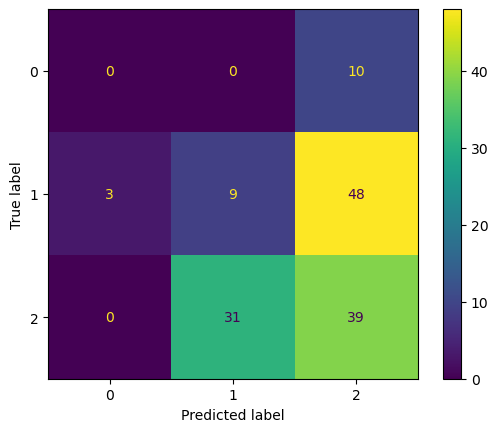

In [22]:
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay
import seaborn as sns

conf_mat = confusion_matrix(y, cv_predictions)
conf_mat_disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
conf_mat_disp.plot()


print(classification_report(y, cv_predictions))

# Analysis 2: Determine overall best hyperparameters for further analysis (single-level cross-validation)
These overall best hyperparameters can be used to gain insight in the model and perform analysis like determining
the optimal number of features or permutation feature importance testing

In [316]:
cv = StratifiedKFold(n_splits=n_cv_splits, shuffle=True, random_state=0)

gridsearch_2 = GridSearchCV(
    pipe,
    param_grid=param_grid,
    scoring=scoring['f1_macro'],
    cv=cv,
    n_jobs=5,
    verbose=4,
)

gridsearch_2.fit(X,y)

#Save
joblib.dump(gridsearch_2, f"Results/model/gridsearch_2_{atlas_dimension}_{phenotype}_chunk.pkl")
print(f"Saved gridsearch_2_{atlas_dimension}_{phenotype}_corr")

#Import
#gridsearch_2 = joblib.load(f"Results/model/gridsearch_2_{atlas_dimension}_{phenotype}.pkl")

Fitting 5 folds for each of 49 candidates, totalling 245 fits
Saved gridsearch_2_64_employ_corr


In [317]:
best_model = gridsearch_2.best_estimator_
param_results = pd.DataFrame(gridsearch_2.cv_results_)

print(gridsearch_2.best_params_)

{'knn__n_neighbors': 5, 'nca__n_components': 16}


## Plot performance over number of features

KeyError: 'select__k'

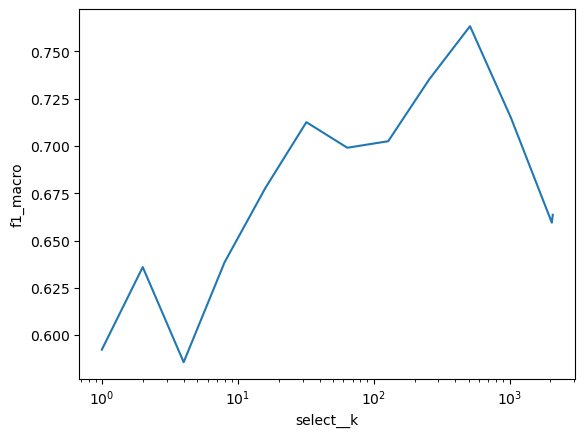

In [116]:
import matplotlib.pyplot as plt

select__k_score = param_results.groupby('param_select__k')['mean_test_score'].max()


ax = plt.gca()
ax.plot(select__k_score.index, select__k_score)
ax.set_xscale('log')
ax.set_xlabel('select__k')
ax.set_ylabel('f1_macro')
ax.set_xticks(param_grid['select__k']);
ax.set_xticklabels(param_grid['select__k'], rotation=90);

## Plot performance over number of NCA components

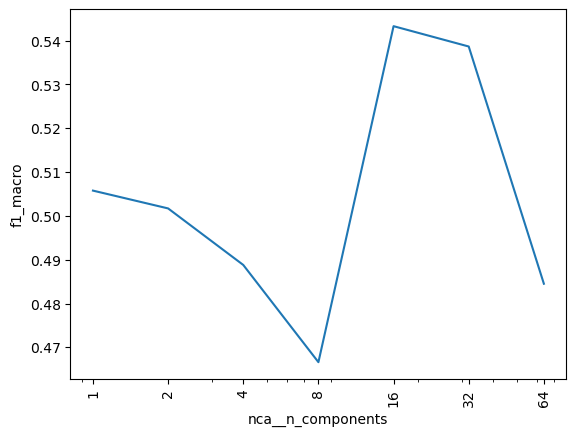

In [318]:
nca__n_components_score = param_results.groupby('param_nca__n_components')['mean_test_score'].max()

ax = plt.gca()
ax.plot(nca__n_components_score.index, nca__n_components_score)
ax.set_xscale('log')
ax.set_xlabel('nca__n_components')
ax.set_ylabel('f1_macro')
ax.set_xticks(param_grid['nca__n_components']);
ax.set_xticklabels(param_grid['nca__n_components'], rotation=90);

## Plot performance over number of kNN neighbors

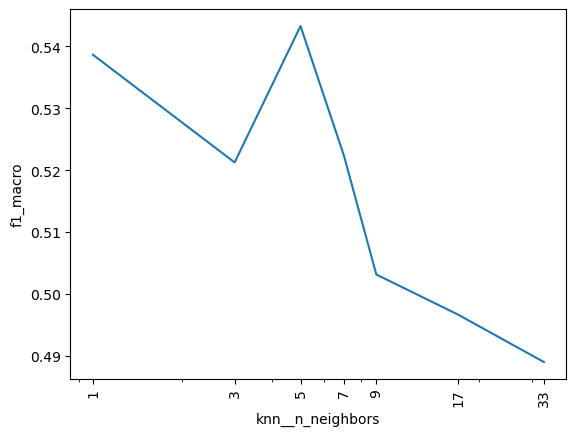

In [319]:
knn__n_neighbors_score = param_results.groupby('param_knn__n_neighbors')['mean_test_score'].max()

ax = plt.gca()
ax.plot(knn__n_neighbors_score.index, knn__n_neighbors_score)
ax.set_xscale('log')
ax.set_xlabel('knn__n_neighbors')
ax.set_ylabel('f1_macro')
ax.set_xticks(param_grid['knn__n_neighbors']);
ax.set_xticklabels(param_grid['knn__n_neighbors'], rotation=90);

<Axes: >

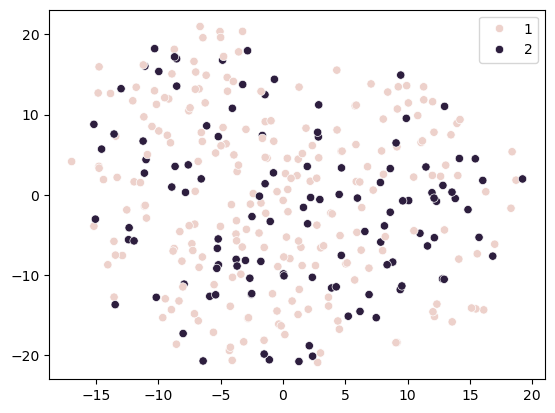

In [320]:
import seaborn as sns
from sklearn.manifold import TSNE

Xt = best_model[:-1].fit_transform(X,y)
Xt = TSNE(n_components=2).fit_transform(Xt,y)
sns.scatterplot(x=Xt[:,0],y=Xt[:,1], hue=y)

using the NCA itself as dimensionality reduction for visualization

In [321]:
Xt = best_model[:-2].fit_transform(X,y)
Xt = NeighborhoodComponentsAnalysis(n_components=2).fit_transform(Xt,y)
sns.scatterplot(x=Xt[:,0],y=Xt[:,1], hue=y)

AttributeError: This 'Pipeline' has no attribute 'fit_transform'

# Analysis 3: Feature importance analysis

Instead of holding out a single test split, we'll also use cross-validation for the PFI to obtain a more stable result while stilldetermining feature importance with held-out data.
The PFI also includes the mRMR feature selection step as part of the model. For folds/permutations where the feature is not retained by the feature selection step, the PFI score will be 0. If it is 0 for all folds, it was never selected. This strategy gives a score for every feature.
Alternatively, we could first retain the earlier determined optimal number of features overall with mRMR and perform PFI testin only for the retained features, which results in e.g. less statistical comparisons.

In [322]:
n_permutations_per_fold=30

In [323]:
from sklearn.inspection import permutation_importance
from sklearn.base import clone
import scipy.stats

pfi_cv = StratifiedKFold(n_splits=n_cv_splits, shuffle=True, random_state=0)
 

df_pfi = []
for fold, (train_idc, test_idc) in enumerate(pfi_cv.split(X,y)):
    fitted_model = best_model.fit(X[train_idc], y[train_idc])
    r = permutation_importance(fitted_model, X[test_idc], y[test_idc], n_repeats=n_permutations_per_fold, n_jobs=-1, scoring=scoring['f1_macro'], random_state=0)
    fold_df_pfi = pd.DataFrame(r.importances)
    df_pfi.append(fold_df_pfi)

df_pfi = pd.concat(df_pfi, axis=1)
df_pfi.index.name='feature'
df_pfi.columns.name='permutation'
df_pfi['p_value'] = df_pfi.apply(lambda row: scipy.stats.ttest_1samp(row, 0).pvalue, axis=1)
df_pfi = df_pfi.melt(value_name='importance', ignore_index=False, id_vars='p_value').reset_index()
df_pfi

[CV 3/5] END knn__n_neighbors=1, nca__n_components=1;, score=0.441 total time=   0.1s
[CV 1/5] END knn__n_neighbors=1, nca__n_components=2;, score=0.620 total time=   0.3s
[CV 3/5] END knn__n_neighbors=1, nca__n_components=2;, score=0.439 total time=   0.6s
[CV 5/5] END knn__n_neighbors=1, nca__n_components=4;, score=0.481 total time=   0.7s
[CV 5/5] END knn__n_neighbors=1, nca__n_components=8;, score=0.376 total time=   0.3s
[CV 4/5] END knn__n_neighbors=1, nca__n_components=16;, score=0.525 total time=   0.3s
[CV 2/5] END knn__n_neighbors=1, nca__n_components=32;, score=0.552 total time=   0.3s
[CV 5/5] END knn__n_neighbors=1, nca__n_components=32;, score=0.490 total time=   1.1s
[CV 3/5] END knn__n_neighbors=3, nca__n_components=2;, score=0.452 total time=   0.0s
[CV 1/5] END knn__n_neighbors=3, nca__n_components=4;, score=0.443 total time=   0.0s
[CV 4/5] END knn__n_neighbors=3, nca__n_components=4;, score=0.469 total time=   0.0s
[CV 1/5] END knn__n_neighbors=3, nca__n_components=

,feature,p_value,permutation,importance
0,0,0.000215,0,0.0
1,1,0.000426,0,0.0
2,2,0.051732,0,0.0
3,3,0.000277,0,0.0
4,4,0.012854,0,0.0
...,...,...,...,...
311995,2075,0.667228,29,0.0
311996,2076,0.318932,29,0.0
311997,2077,0.000061,29,0.0
311998,2078,0.002574,29,0.0


In [324]:
import joblib
# Save the results
joblib.dump(df_pfi, f"Results/model/df_pfi_{atlas_dimension}_{phenotype}_corr.pkl")
print(f"cv_results saved to Results/model/df_pfi_{atlas_dimension}_{phenotype}_corr.pkl")

cv_results saved to Results/model/df_pfi_64_employ_corr.pkl


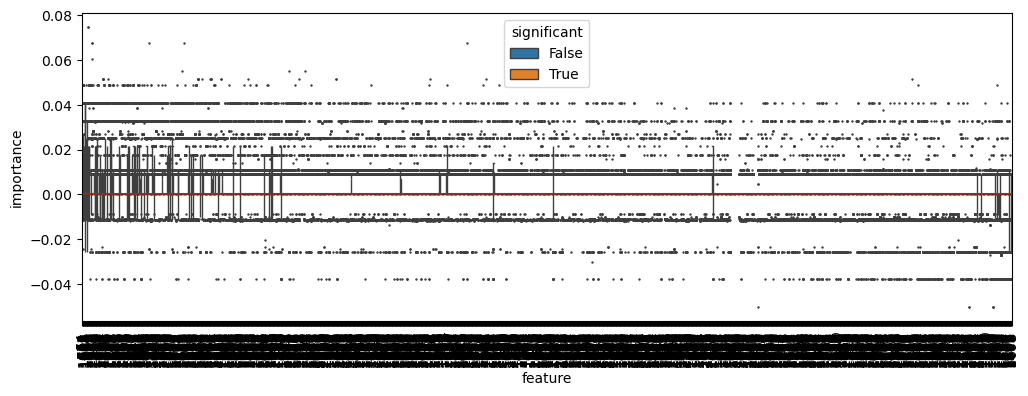

In [325]:
df_pfi['significant'] = df_pfi['p_value'] < 0.05 / n_features # Bonferroni multiple comparisons correction
mean_by_feature = df_pfi.groupby(['feature'])['importance'].mean().sort_values(ascending=False)
sns.boxplot(data=df_pfi, x='feature', y='importance', hue='significant', order=mean_by_feature.index, fliersize=1, flierprops=dict(marker="+"))
plt.xticks(rotation=90)
plt.gcf().set_size_inches(12,4)
plt.axhline(0, color='red')

same but without the non-selected features for readability

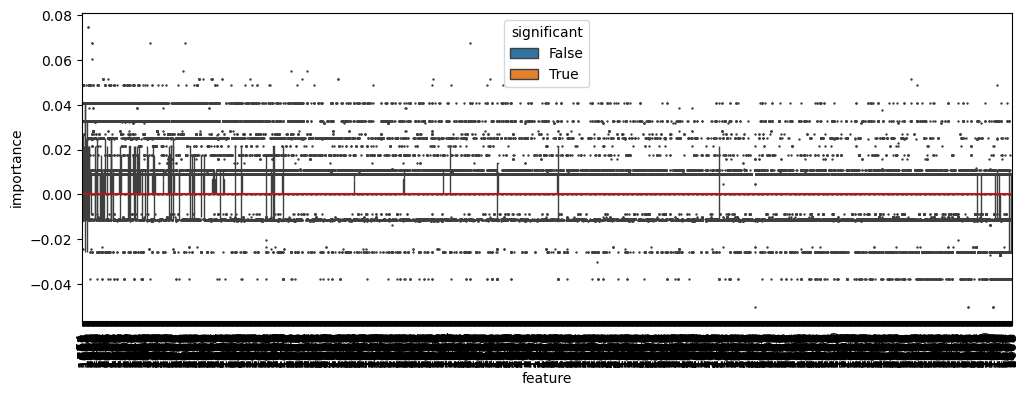

In [326]:
mean_by_feature = df_pfi.groupby(['feature'])['importance'].mean()
mean_by_feature = mean_by_feature[mean_by_feature != 0]
mean_by_feature = mean_by_feature.sort_values(ascending=False)
sns.boxplot(data=df_pfi, x='feature', y='importance', hue='significant', order=mean_by_feature.index,fliersize=1, flierprops=dict(marker="+"))
plt.xticks(rotation=90)
plt.gcf().set_size_inches(12,4)
plt.axhline(0, color='red')

In [327]:
#Group by feature and calculate mean and standard deviation
stats = df_pfi.groupby('feature').agg({
    'importance': ['mean', 'std'],  # Calculate both mean and std
    'p_value': 'mean'               
})

# Flatten the multi-level columns
stats.columns = ['mean_importance', 'std_importance', 'mean_p_value']

# Filter for features with mean - 2*std > 0
filtered_stats = stats[stats['mean_importance'] - 2 * stats['std_importance'] > 0]

# Sort by mean importance
filtered_stats = filtered_stats.sort_values(by='mean_importance', ascending=False)

# Print the count and the filtered features
print(f"Number of significant features with mean - 2*std > 0: {len(filtered_stats)}\n")
print("Filtered significant features with mean, std, and p-value:")
print(filtered_stats)

Number of significant features with mean - 2*std > 0: 0

Filtered significant features with mean, std, and p-value:
Empty DataFrame
Columns: [mean_importance, std_importance, mean_p_value]
Index: []
